In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import ticker, cm

import matplotlib.ticker as ticker

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

colors={'direct':'#3d7f1e',
        'indirect':'#b1116d',
        'total':'darkorange'
        }

def truncate(n, decimals=0):
    multiplier = 10**decimals
    return int(n * multiplier) / multiplier

In [3]:
macsp = xr.open_dataset('/home/anthe/documents/misu/thesis/MAC-SP.nc')

prp = xr.open_dataset('../../albedo/datasets/historical-CR_single-plumes_3D_PRP_monmean_1950-2013.nc')
macsp.year_weight.isel(plume_number=1)


<xarray.DataArray 'year_weight' (years: 251)>
[251 values with dtype=float32]
Coordinates:
    plume_number  int32 2
  * years         (years) int32 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
Attributes:
    unit:       Amplitude relative to 2005, scaled by CEDS emissions
    long_name:  Annual Scaling factor for plume amplitude

In [17]:
def aod():
    prp = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/datasets/dR_sp_monmean.nc')
        
    aod_sp = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/aod_sp/datasets/aod_sp_2005.nc').squeeze()
    macsp = xr.open_dataset('/home/anthe/documents/misu/thesis/MAC-SP.nc')

    aod = prp.dR_sp_srad0*0

    for y in range(0, (2013-1850)+1, 1):
        for m in range(0, 12, 1):
            t = y*12 + m
            for i in range(1, 10, 1):

                aod[t,:,:] += aod_sp[f'aod_sp{i}'].isel(time=m)*macsp.year_weight.sel(plume_number=i).isel(years=y)
    return aod.rename('aod_sp')
    #aod.rename('aod_sp').to_netcdf(path='/home/anthe/documents/misu/paper_aerosols/datasets/aod_sp.nc',mode='w')
aod_sp = aod()

In [5]:
def aod():
    prp = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/datasets/dR_sp_monmean.nc')
        
    aod_sp = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/aod_sp/datasets/aod_sp_2005.nc').squeeze()
    #macsp = xr.open_dataset('/home/anthe/documents/misu/thesis/MAC-SP.nc')

    for i in range(1, 10, 1):
        aod = prp[f'dR_sp_srad0']*0
        for y in range(0, (2013-1850)+1, 1):
            for m in range(0, 12, 1):
                t = y*12 + m
                
                aod[t,:,:] += aod_sp[f'aod_sp{i}'].isel(time=m)*macsp.year_weight.sel(plume_number=i).isel(years=y)
        

        #aod.rename(f'aod_sp{i}').to_netcdf(path=f'/home/anthe/documents/misu/paper_aerosols/datasets/aod_sp{i}.nc',mode='w')

aod()

In [34]:
def aod_yearmean(aod):
    prp = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/datasets/dR_sp_monmean.nc')

    aod_yearmean = prp.dR_sp_srad0*0

    for y in range(0, (2013-1850)+1, 1):
        aod_yearmean[y,:,:] = aod[y*12:y*12+12,:,:].mean(dim='time')

    return aod_yearmean

aod_sp_yearmean = aod_yearmean(aod_sp)

In [12]:
aod_bg.to_netcdf(path='/home/anthe/documents/misu/paper_aerosols/aod_bg.nc',mode='w')

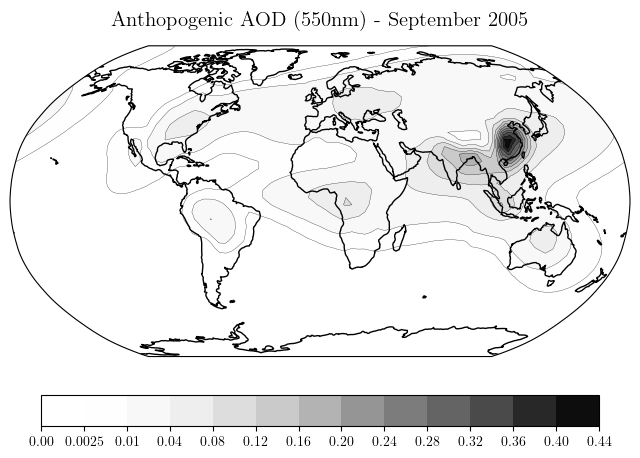

In [5]:
def plot():
    aod_sp_2005 = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/aod_sp/datasets/aod_sp_2005.nc').squeeze()
    aod_sp_2005_yearmean = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/aod_sp/datasets/aod_sp_2005_yearmean.nc').squeeze()

    central_longitude = 0
    projectionStyle = ccrs.Robinson(central_longitude=central_longitude)

    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(projection=projectionStyle))
    year = 2005
    month = 9
    var = aod_sp.isel(time=(year-1950)*12 + month)# + aod_sp_2005.aod_bg.isel(time=month)
    #var = aod_sp_yearmean.isel(time=year-1950) + aod_sp_2005_yearmean.aod_bg
    lon = var.coords['lon']
    lon_idx = var.dims.index('lon')
    wrap_var, wrap_lon = add_cyclic_point(var.values, coord=lon, axis=lon_idx)
    formatter = ticker.FormatStrFormatter('%.2f')

    #level = np.linspace(0.0, 0.45, 16)
    level = [0, 0.0025, 0.01, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44]
    pc = ax.contourf(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        cmap='Greys',
        levels= level,
        #locator=ticker.LogLocator()
        #extend='both',
    )
    C = ax.contour(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        colors='black',
        levels= level,
        #alpha=0.8,
        linewidths=.2
    )
    axins = inset_axes(ax, width='90%', height='10%', loc='lower center', borderpad= -5)
    cb = plt.colorbar(pc, cax=axins, ax=ax, orientation='horizontal', pad=0.04, ticks=level)

    def custom_formatter(x, pos):
        if x == 0.0025:
            return '0.0025%'
        return formatter(x, pos)

    cb.ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
    ax.coastlines()

    ax.set_title('Anthopogenic AOD (550nm) - September 2005', pad =15, fontsize=15)

    fig.savefig('../figures/aod_sp_2005_sep.pdf')

plot()


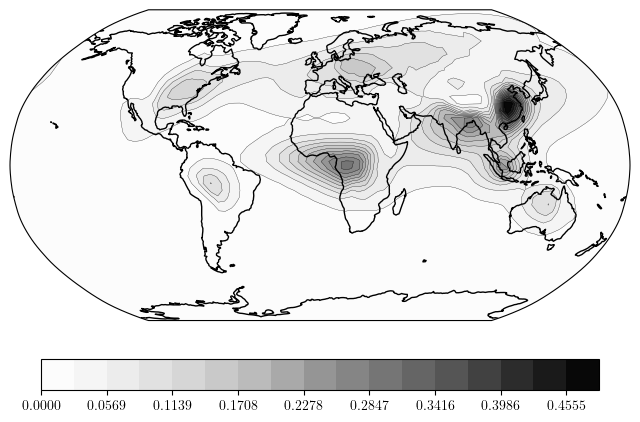

In [18]:
def plot():

    aod_sp = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/aod_sp/datasets/aod_sp_2005_yearmean.nc').squeeze()

    central_longitude = 0
    projectionStyle = ccrs.Robinson(central_longitude=central_longitude)

    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(projection=projectionStyle))
    year = 2005
    month = 9
    #var = aod_sp.aod_sp.isel(time=month) + aod_sp.aod_bg.isel(time=month)
    var = (
        aod_sp.aod_sp 
        + 
        aod_sp.aod_bg
    )
    lon = var.coords['lon']
    lon_idx = var.dims.index('lon')
    wrap_var, wrap_lon = add_cyclic_point(var.values, coord=lon, axis=lon_idx)

    #cmap = mcolors.LinearSegmentedColormap.from_list('diverging_cmap', ['#00008B', '#FFFFFF', '#990000'])
    level = np.linspace(0, var.max(), 18)
    pc = ax.contourf(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        cmap='Greys',
        levels= level,
        #extend='both',
        #alpha=0.8,
    )
    C = ax.contour(wrap_lon,
        var.lat,
        wrap_var,
        transform=ccrs.PlateCarree(),
        colors='black',
        levels= level,
        #alpha=0.8,
        linewidths=.2
    )
    axins = inset_axes(ax, width='90%', height='10%', loc='lower center', borderpad= -5)
    cb = plt.colorbar(pc, cax=axins, ax=ax, orientation='horizontal', pad=0.04)#, ticks=np.arange(Nmin, Nmax + 1, 2.5), label=label)
    ax.coastlines()

plot()


In [25]:
def forcing_aod(ax, type):

    if type == 'all-sky':
        srad = xr.open_dataset('../../albedo/datasets/historical-CR_single-plumes_3D_BOT_monmean_1950-2013.nc')
        prp = xr.open_dataset('../../albedo/datasets/historical-CR_single-plumes_3D_PRP_monmean_1950-2013.nc')
            
        #aod_sp = xr.open_dataset('/home/anthe/documents/misu/paper_aerosols/aod_sp/datasets/aod_sp_2005.nc').squeeze()
        macsp = xr.open_dataset('/home/anthe/documents/misu/thesis/MAC-SP.nc')

        forcing = (prp.dR_spd_srad0 + prp.dR_spd_trad0)

        ax.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]')
        
    elif type == 'clear-sky':
       # srad = xr.open_dataset('../datasets/historical-CR_single-plumes_clear-sky_BOT_monmean_1950-2013.nc')
        prp = xr.open_dataset('../../clear-sky/datasets/historical-CR_single-plumes_clear-sky_PRP_monmean_1950-2013.nc')
        forcing = (prp.dR_spd_sraf0 + prp.dR_spd_traf0)

        ax.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]')

    
    ax.hexbin(aod_sp.isel(time=slice(12*(1950-1850),12*(2014-1850))), forcing, gridsize=600, bins='log', cmap='plasma')
    ax.axhline(0, color='black', linewidth=0.8)
    #ax.axvline(0.5, color='black', linewidth=0.8)
    #ax.set_xlim([0.0,1])

    #ax.set_xlabel('Planetary albedo')


    return 0

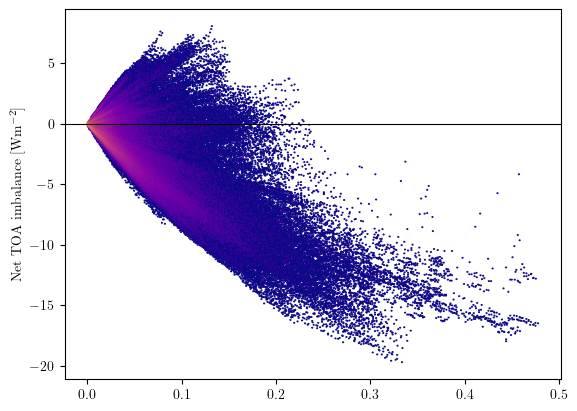

In [28]:
def plot():

    fig, ax = plt.subplots(1,1)

    forcing_aod(ax, 'clear-sky')


plot()


/home/anthe/anaconda3/envs/misu/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


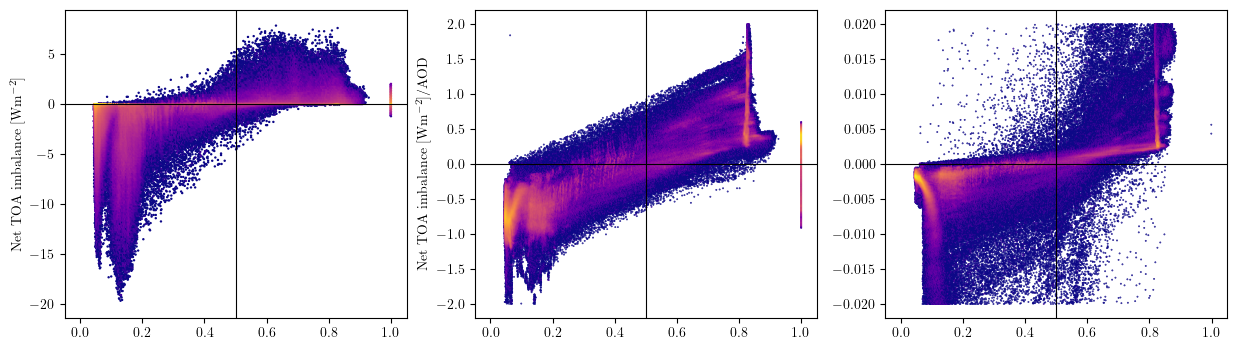

In [32]:
def plot_direct():
    srad = xr.open_dataset('../../clear-sky/datasets/historical-CR_single-plumes_clear-sky_BOT_monmean_1950-2013.nc')
    prp = xr.open_dataset('../../albedo/datasets/historical-CR_single-plumes_3D_PRP_monmean_1950-2013.nc')
    clearSky = xr.open_dataset('../../clear-sky/datasets/historical-CR_single-plumes_clear-sky_PRP_monmean_1950-2013.nc')

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,4))
    albedo = (- srad.sradsu /(srad.srads - srad.sradsu))#/srad.srad0d
    albedo = albedo.where((albedo>0) | (albedo<1))
    forcing = clearSky.dR_sp_sraf0 #+ clearSky.dR_sp_traf0
    
    ax1.hexbin(albedo, forcing, gridsize=300, 
               extent=[0,1,-20,8], 
               bins='log', cmap='plasma')
    ax1.axhline(0, color='black', linewidth=0.8)
    ax1.axvline(0.5, color='black', linewidth=0.8)
    #plt.xlim([0.0,1])
    ax1.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]')

    forcing = forcing/(aod_sp*100)
    ax2.hexbin(albedo, forcing, gridsize=600, 
               extent=[0,1,-2,2], 
               bins='log', 
               cmap='plasma')
    ax2.axhline(0, color='black', linewidth=0.8)
    ax2.axvline(0.5, color='black', linewidth=0.8)

    forcing = forcing.values/srad.srad0d
    ax3.hexbin(albedo, forcing, gridsize=600, 
               extent=[0,1,-0.02,0.02], 
               bins='log', 
               cmap='plasma')
    ax3.axhline(0, color='black', linewidth=0.8)
    ax3.axvline(0.5, color='black', linewidth=0.8)
    #plt.xlim([0.0,1])

    #plt.xlabel('Surface albedo')
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]/AOD')

    #ax2.title('Direct effect against surface albedo')

plot_direct()

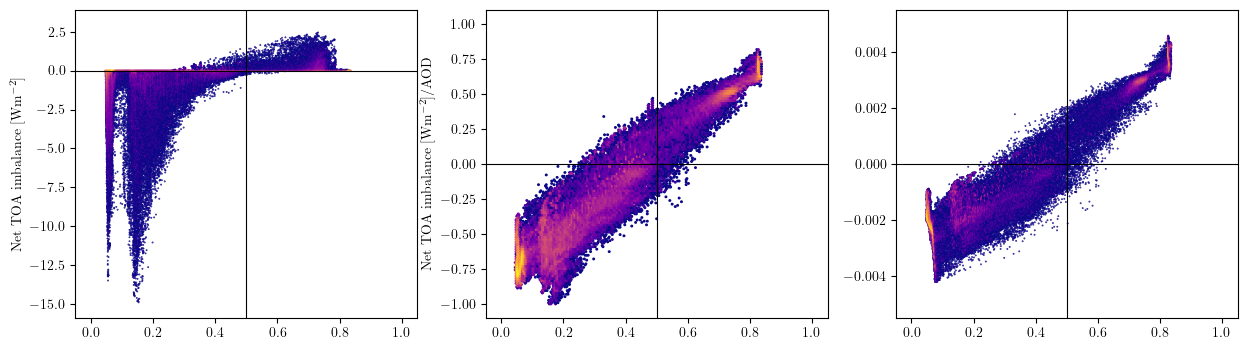

In [40]:
def plot_direct():
    srad = xr.open_dataset('../../clear-sky/datasets/historical-CR_single-plumes_clear-sky_BOT_yearmean_1950-2013.nc')
    prp = xr.open_dataset('../../albedo/datasets/historical-CR_single-plumes_3D_PRP_yearmean_1950-2013.nc')
    clearSky = xr.open_dataset('../../clear-sky/datasets/historical-CR_single-plumes_clear-sky_PRP_yearmean_1950-2013.nc')

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,4))
    albedo = (- srad.sradsu /(srad.srads - srad.sradsu))#/srad.srad0d
    albedo = albedo.where((albedo>0) | (albedo<1))
    forcing = clearSky.dR_sp_sraf0 #+ clearSky.dR_sp_traf0
    
    ax1.hexbin(albedo, forcing, gridsize=600, 
               extent=[0,1,-15,3], 
               bins='log', cmap='plasma')
    ax1.axhline(0, color='black', linewidth=0.8)
    ax1.axvline(0.5, color='black', linewidth=0.8)
    #plt.xlim([0.0,1])
    ax1.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]')

    forcing = forcing/(aod_sp_yearmean.isel(time=slice(100,2014-1850)).values*100)
    ax2.hexbin(albedo, forcing, gridsize=200, 
               extent=[0,1,-1,1], 
               bins='log', 
               cmap='plasma')
    ax2.axhline(0, color='black', linewidth=0.8)
    ax2.axvline(0.5, color='black', linewidth=0.8)

    forcing = forcing.values/srad.srad0d
    ax3.hexbin(albedo, forcing, gridsize=600, 
               extent=[0,1,-0.005,0.005], 
               bins='log', 
               cmap='plasma')
    ax3.axhline(0, color='black', linewidth=0.8)
    ax3.axvline(0.5, color='black', linewidth=0.8)
    #plt.xlim([0.0,1])

    #plt.xlabel('Surface albedo')
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]/AOD')

    #ax2.title('Direct effect against surface albedo')

plot_direct()

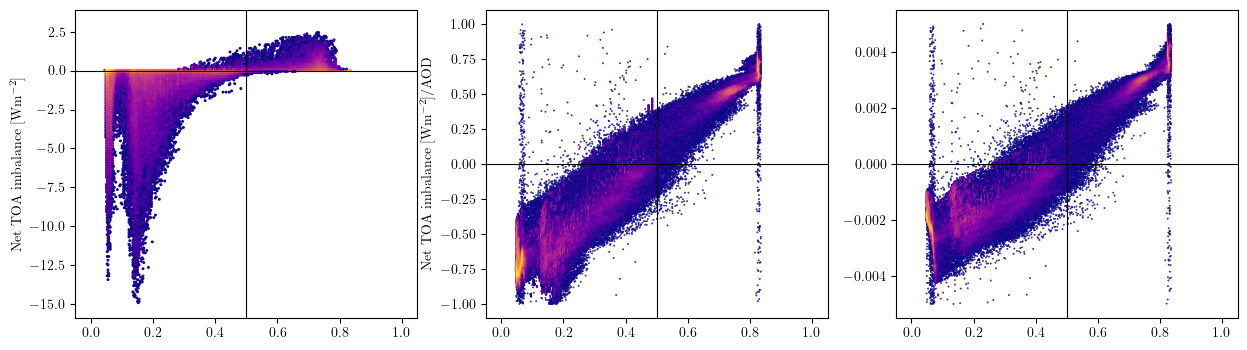

In [10]:
def plot_direct():

    data = xr.open_dataset('../../datasets/historical_simple-plumes_PRP_BOT_aod_yearmean.nc').squeeze()

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,4))
    albedo = (- data.sradsu /(data.srads - data.sradsu))#/srad.srad0d
    albedo = albedo.where((albedo>0) | (albedo<1))
    forcing = data.dR_sp_sraf0 #+ clearSky.dR_sp_traf0
    
    ax1.hexbin(albedo, forcing, gridsize=200, 
               extent=[0,1,-15,3], 
               bins='log', cmap='plasma')
    ax1.axhline(0, color='black', linewidth=0.8)
    ax1.axvline(0.5, color='black', linewidth=0.8)
    #plt.xlim([0.0,1])
    ax1.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]')

    forcing = forcing/(data.aod_sp*100)
    ax2.hexbin(albedo, forcing, gridsize=600, 
               extent=[0,1,-1,1], 
               bins='log', 
               cmap='plasma')
    ax2.axhline(0, color='black', linewidth=0.8)
    ax2.axvline(0.5, color='black', linewidth=0.8)

    forcing = forcing.values/data.srad0d
    ax3.hexbin(albedo, forcing, gridsize=600, 
               extent=[0,1,-0.005,0.005], 
               bins='log', 
               cmap='plasma')
    ax3.axhline(0, color='black', linewidth=0.8)
    ax3.axvline(0.5, color='black', linewidth=0.8)
    #plt.xlim([0.0,1])
    

    #plt.xlabel('Surface albedo')
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]/AOD')

    #ax2.title('Direct effect against surface albedo')

plot_direct()

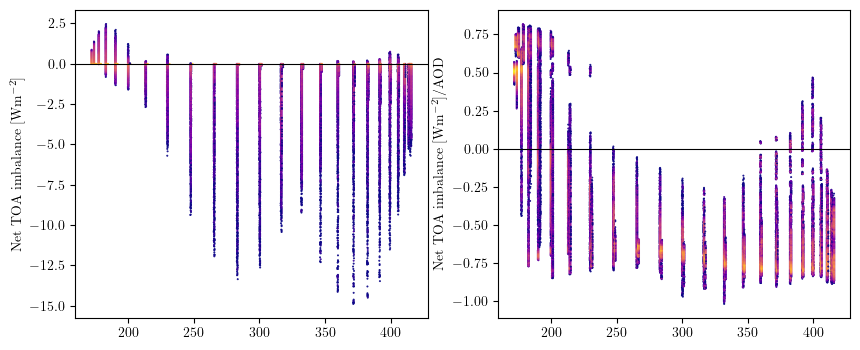

In [15]:
def plot_direct():
    srad = xr.open_dataset('../../clear-sky/datasets/historical-CR_single-plumes_clear-sky_BOT_yearmean_1950-2013.nc')
    prp = xr.open_dataset('../../albedo/datasets/historical-CR_single-plumes_3D_PRP_monmean_1950-2013.nc')
    clearSky = xr.open_dataset('../../clear-sky/datasets/historical-CR_single-plumes_clear-sky_PRP_yearmean_1950-2013.nc')

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
        #time = year - 1850
    #albedo = - srad.sradsu.isel(time=time) /(srad.srads.isel(time=time) - srad.sradsu.isel(time=time))
    irradiance = srad.srad0d
    forcing = (clearSky.dR_sp_sraf0 + clearSky.dR_sp_traf0)
    
    ax1.hexbin(irradiance, forcing, gridsize=500, 
               #extent=[0,1,-20,8], 
               bins='log', cmap='plasma')
    ax1.axhline(0, color='black', linewidth=0.8)
    #ax1.axvline(0.5, color='black', linewidth=0.8)
    #plt.xlim([0.0,1])
    ax1.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]')

    forcing = (clearSky.dR_sp_sraf0 + clearSky.dR_sp_traf0)/(aod_sp_yearmean*100)
    #plt.scatter(albedo, forcing, s=1, color='black', marker='x', linewidths=1)
    ax2.hexbin(irradiance, forcing, gridsize=500, 
               #extent=[0,1,-2,2], 
               bins='log', cmap='plasma')
    ax2.axhline(0, color='black', linewidth=0.8)
    #ax2.axvline(0.5, color='black', linewidth=0.8)
    #plt.xlim([0.0,1])

    #plt.xlabel('Surface albedo')
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]/AOD')

    #ax2.title('Direct effect against surface albedo')

plot_direct()